## 1. Data loading and pre-processing

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import urllib.parse
from collections import defaultdict, deque
from src.utils.pagerank_utils import *

In [2]:
# Load all the data from the tsv files, skipping the headers and specifying column names
DATA_FOLDER = 'data/wikispeedia_paths-and-graph/'
articles = pd.read_csv(DATA_FOLDER + 'articles.tsv', sep='\t', skiprows=12, names=['article'])
categories = pd.read_csv(DATA_FOLDER + 'categories.tsv', sep='\t', skiprows=12, names=['article', 'category'])
links = pd.read_csv(DATA_FOLDER + 'links.tsv', sep='\t', skiprows=11, names=['linkSource', 'linkTarget'])
paths_finished = pd.read_csv(DATA_FOLDER + 'paths_finished.tsv', sep='\t', skiprows=15, names=['hashedIpAddress', 'timestamp', 'durationInSec', 'path', 'rating'])
paths_unfinished = pd.read_csv(DATA_FOLDER + 'paths_unfinished.tsv', sep='\t', skiprows=16, names=['hashedIpAddress', 'timestamp', 'durationInSec', 'path', 'target', 'type'])

In [3]:
# Decode the URL-encoded article titles
articles = articles.map(urllib.parse.unquote)
categories = categories.map(urllib.parse.unquote)
links = links.map(urllib.parse.unquote)
paths_finished['path'] = paths_finished['path'].map(urllib.parse.unquote)
paths_unfinished['path'] = paths_unfinished['path'].map(urllib.parse.unquote)

In [4]:
# Turn the paths into an array of article titles
paths_finished['path'] = paths_finished['path'].str.split(';')
paths_unfinished['path'] = paths_unfinished['path'].str.split(';')

In [5]:
# Articles is a 1-column DataFrame, so convert it to a Series
articles = pd.Series(articles['article'])

## 2. Compute probabilities and entropies

### 2.A. Prior click probability

![Formula for the prior click probability](./images/probs_prior.png)

In [6]:
# Prior click probability

# The probability to click on each of article a’s L_a outlinks is the same for all outlinks
# So we don’t need a third dimension to index the specific outlinks

# Actually, it doesn’t depend either on the goal, because our prior is that the links are clicked randomly

# Count the outlinks of each article to get the probability of clicking on any of them
out_degree = links.groupby('linkSource').size()
probs_prior = 1 / out_degree
# Create a Series indexed by 'linkSource' that gives a list of all the source’s outlinks
out_links = links.groupby('linkSource')['linkTarget'].agg(list)
# Convert it to a default dict to cover for articles that are encountered in paths but that have no outlinks
#out_links = defaultdict(int, out_links.to_dict())

### 2.B. Posterior click probability

![Formula for the posterior click probability](./images/probs_posterior.png)

In [7]:
# N(A=a, G=g): the number of times 'a' was encountered on paths for which 'g' was the goal
count_goal_article = defaultdict(lambda: defaultdict(int))
# N(A’=a’, A=a, G=g): the number of times a’ was clicked in this situation
count_goal_article_article_clicked = defaultdict(lambda: defaultdict(lambda: defaultdict(int)))
# Filter out the paths that have only one article, because I have no clue what they mean
paths = paths_finished['path'][paths_finished['path'].apply(len) > 1]

# Create simplified paths by getting rid of the backtracking steps, and going straight
# where the player ended up going after backtracking
def straighten_path(path):
    stack = deque()
    for article in path:
        if article == '<':
            stack.pop()
        else:
            stack.append(article)
    return list(stack)

paths_no_backtrack = paths.apply(straighten_path)

# Count the occurrences of a, a’ and g along every path
for path in paths_no_backtrack:
    goal = path[-1]
    # Iterate through the path by getting each time one article and the one that was clicked from it.
    # It starts at (start_article, first_article_clicked) and ends with (before_last_article, goal).
    for article, article_clicked in zip(path, path[1:]):
        count_goal_article[goal][article] += 1
        count_goal_article_article_clicked[goal][article][article_clicked] += 1

In [8]:
# Posterior click probabilities
probs_posterior = defaultdict(lambda: defaultdict(lambda: defaultdict(int)))
# alpha_ is the Dirichlet parameter representing the initial confidence in the uniform prior distribution
alpha_ = 0.1

for g, article_counts in count_goal_article.items():
    for a, count in article_counts.items():
        for a_ in out_links[a]:
            # Use the formula (1) from the Wikispeedia paper
            probs_posterior[g][a][a_] = (
                    (count_goal_article_article_clicked[g][a][a_] + alpha_)
                    /
                    (count_goal_article[g][a] + alpha_ * out_degree[a])
            )

### 2.C. Prior and posterior entropies

In [9]:
# Compute the prior and posterior entropy at each article along the path, except for the goal,
# because entropy is 0 once we have reached the goal.

def path_to_prior_entropy(path):
    return [-1 * out_degree[a] * probs_prior[a] * np.log(probs_prior[a]) for a in path[:-1]]

def path_to_posterior_entropy(path):
    g = path[-1]
    return [(-1 * sum([prob * np.log(prob) for prob in probs_posterior[g][a].values()])) for a in path[:-1]]

entropies_prior = paths_no_backtrack.apply(path_to_prior_entropy)
entropies_posterior = paths_no_backtrack.apply(path_to_posterior_entropy)

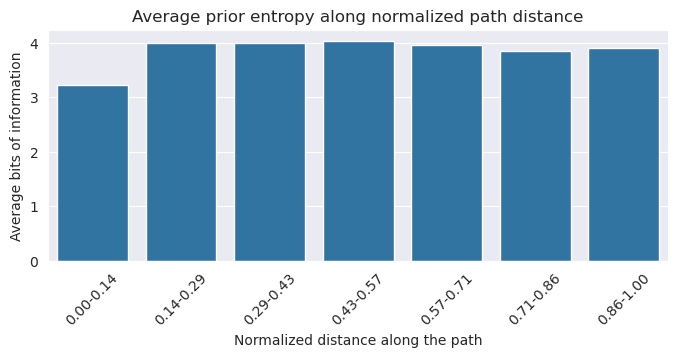

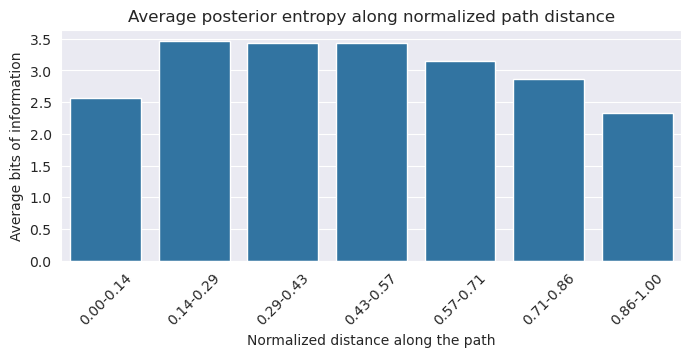

In [10]:
# Visualize the entropies like in Fig. 2 of the Wikispeedia paper
def plot_normalized_positions(series, graph_title, n_bins=7):
    """
    Create a bar plot of binned averages along the length of an array,
    but plotted along an x-axis normalized to [0,1].
    
    Parameters:
    series: pandas.Series where each element is an array of numbers
    graph_titre: string with the name of the quantity plotted
    n_bins: number of bins to divide the [0,1] interval into
    """
    # Create empty lists to store normalized positions and values
    all_positions = []
    all_values = []

    # Process each array in the series
    for arr in series:
        length = len(arr)
        # Create normalized positions for this array
        positions = np.linspace(0, 1, length)

        all_positions.extend(positions)
        all_values.extend(arr)

    # Create a DataFrame with the normalized positions and values
    df = pd.DataFrame({
        'position': all_positions,
        'value': all_values
    })

    # Create bins and calculate statistics for each bin
    df['bin'] = pd.cut(df['position'], bins=n_bins, labels=[f'{i/n_bins:.2f}-{(i+1)/n_bins:.2f}' for i in range(n_bins)])

    bin_stats = df.groupby('bin', observed=True).agg({
        'value': ['mean']
    }).reset_index()

    # Flatten the column names
    bin_stats.columns = ['bin', 'mean']

    # Create the plot
    plt.figure(figsize=(8, 3))
    sns.barplot(data=bin_stats, x='bin', y='mean')

    plt.title(f'Average {graph_title} along normalized path distance')
    plt.xlabel('Normalized distance along the path')
    plt.ylabel('Average bits of information')
    plt.xticks(rotation=45)

    return plt.gcf()

plot_normalized_positions(entropies_prior, 'prior entropy')
plt.show()
plot_normalized_positions(entropies_posterior, 'posterior entropy')
plt.show()

## 3. Split the paths

### 3.A. Compute “information gain”

This represents how much information we gain by looking at the click distribution

In [11]:
# Define a function to subtract two lists element-wise
def subtract_lists(list1, list2):
    return [a - b for a, b in zip(list1, list2)]

# Subtract posterior entropy to prior entropy element-wise in each path to obtain information gain
information_gain = entropies_prior.combine(entropies_posterior, subtract_lists)

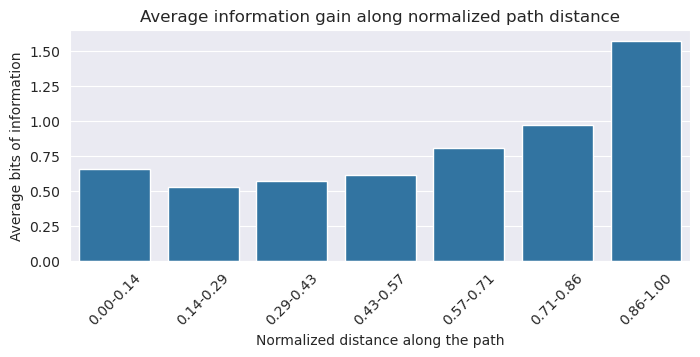

In [12]:
plot_normalized_positions(information_gain, 'information gain')
plt.show()

This is similar to what the paper gets:

![information gain graph from the paper](./images/fig_2_paper.png)

### 3.B. Get the splitting point and split the paths

In [13]:
# Add all the “homing in” parts of the paths in the array, by splitting
# the paths at the point of minimum information

# Get the index of the point of lowest information gain for each path
argmin_info_gain = information_gain.apply(np.argmin)
# Split the path at this point and keep only the second part, corresponding to the “homing in” phase
paths_homing_in = pd.Series([path[argmin_info_gain[i]:] for i, path in paths_no_backtrack.items()])

## 5. Compute embedding distances

We now need to get a list of all the article titles whose embedding we need to compute, as well as the list of pairs of articles between which we need to compute the distance.

In [14]:
# Compute the set of all articles encountered in the paths_homing_in
# Every article encountered along a goal has a defined distance with the goal
# TODO: should they also have a defined distance with all the other articles along the path?
all_distance_pairs = set()
all_articles = set()
for path in paths_homing_in:
    goal  = path[-1]
    for article in path:
        all_articles.add(article)
        all_distance_pairs.add((article, goal))

We use the sentence-transformers library to load the pre-trained BERT model and compute embeddings.

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics.pairwise import cosine_similarity

model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

def get_embedding(text):
    inputs = tokenizer(text, return_tensors="pt")
    with torch.no_grad(): # we are not training the model, so we don't need gradients
        outputs = model(**inputs)
    embedding = outputs.last_hidden_state.mean(dim=1).squeeze()
    return embedding

# calculate the cosine similarity between two embeddings
def calculate_cosine_similarity(emb_title1, emb_title2):
    emb_title1 = emb_title1.reshape(1, -1)
    emb_title2 = emb_title2.reshape(1, -1)

    similarity = cosine_similarity(emb_title1, emb_title2)[0][0]
    return similarity

# get the embeddings of all articles and store them in a dictionary
article_embeddings = {}
for article in all_articles:
    article_embeddings[article] = get_embedding(article)

# calculate the cosine similarity between all pairs of articles
similarities = {}
for pair in all_distance_pairs:
    title1 = pair[0]
    title2 = pair[1]
    embedding1 = article_embeddings[title1]
    embedding2 = article_embeddings[title2]
    similarities[(title1, title2)] = calculate_cosine_similarity(embedding1, embedding2)

# convert the cosine similarities to a dataframe
similarities = pd.DataFrame(similarities.items(), columns=['pair', 'cosine_similarity'])

# we now try another model to calculate the similarity between two articles
from sentence_transformers import SentenceTransformer, util
model = SentenceTransformer('all-MiniLM-L6-v2')

def calculate_sbert_similarity(embedding1, embedding2):
    similarity = util.pytorch_cos_sim(embedding1, embedding2).item()
    return similarity

# get the embeddings of all articles and store them in a dictionary
article_embeddings = {}
for article in all_articles:
    article_embeddings[article] = model.encode(title1, convert_to_tensor=True)

# calculate the cosine similarity between all pairs of articles
similarities_sbert = {}
for pair in all_distance_pairs:
    title1 = pair[0]
    title2 = pair[1]
    embedding1 = article_embeddings[title1]
    embedding2 = article_embeddings[title2]
    similarity =  calculate_sbert_similarity(embedding1, embedding2)
    similarities_sbert[(title1, title2)] = similarity

# add a new column to the dataframe with the SBERT cosine similarities
similarities['sbert_cosine_similarity'] = similarities['pair'].apply(lambda x: similarities_sbert[x])

# now compute the Euclidean distances
from scipy.spatial.distance import euclidean

# Load pre-trained model and tokenizer
model_name = "bert-base-uncased"  # You can use any suitable model here
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)


def get_embedding(text):
    # Tokenize the text and get embeddings
    inputs = tokenizer(text, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs)
    # Pool the output to get a single vector representation of the text
    embedding = outputs.last_hidden_state.mean(dim=1).squeeze()
    return embedding

def calculate_euclidean_distance(title1, title2):
    # Get embeddings
    embedding1 = get_embedding(title1)
    embedding2 = get_embedding(title2)
    # Convert to numpy arrays for distance calculation
    embedding1_np = embedding1.numpy()
    embedding2_np = embedding2.numpy()
    # Calculate Euclidean distance
    distance = euclidean(embedding1_np, embedding2_np)
    return distance

# add a column to the dataframe similarities that contains the Euclidean distance between the embeddings of the articles in each pair
similarities['euclidean_distance'] = similarities['pair'].apply(lambda x: calculate_euclidean_distance(x[0], x[1]))

/home/t/.conda/envs/ada/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 4. Compute semantic distances from paths

### 4.A. PageRank

In [16]:
M, nodes = build_transition_matrix(links)
ranks = pagerank(M)

#Properties that were tested and validated: every rank is inferior to 1, the sum of all ranks is 1.
#Dictionary of pagerank per article.
PAGERANK_SCORES = dict(zip(nodes, ranks))

- Nous avons 5 articles qui ont des inwards links mais pas d'outgoing link (dandling nodes): ['Directdebit', 'Duchenne_muscular_dystrophy', 'Klinefelter%27s_syndrome', 'Local_community', 'Osteomalacia']
- Le plus haut pagerank est atteint par l'article Etats-Unis
- Le pagerank le plus bas est atteint par l'article %C3%81ed%C3%A1n_mac_Gabr%C3%A1in

Todo: vérifier que le pagerank des 5 dandling nodes est bien calculé.

In [17]:
#2 Initialize the distances matrix
# TODO: tu as là-dedans des articles qui ne sont peut-être pas dans les paths homing in
# donc si tu calcules leur distance, tu n’auras pas l’info
nodes = np.unique(links[['linkSource', 'linkTarget']].values.flatten())
distances_counts = pd.DataFrame(0, index=nodes, columns=nodes) #used in computing the average of path distances.
distances = pd.DataFrame(0, index=nodes, columns=nodes) # Interface: distances[article1][article2] = d(article1, article2)

#define path distance computation function
def compute_path_distance(i, path):
    goal = path[-1]
    sum_p = 0
    for i in range(i, len(path) - 1):
        sum_p -= np.log(probs_posterior[goal][path[i]][path[i+1]])
    return sum_p / np.log(PAGERANK_SCORES[goal])

#fill in distances without normalization and distances_count for one path
def path_distances_traversal(path):
    goal = path[-1]
    for i in range(0, len(path) - 1): # len(path) - 1: We don't consider the distance from the goal to itself
        distances[path[i]][goal] += compute_path_distance(i, path)
        distances_counts[path[i]][goal] += 1
    return path

#3 Compute the distances and distances_counts matrix by passing through all the paths and incrementing the two matrices accordingly
paths_homing_in.apply(path_distances_traversal)

#4 Normalize the distances according to the number of occurences of given distance in the paths
distances_counts[distances_counts == 0] = 1 # avoid dividing by zero
distances = distances / distances_counts

# Put every undefined distance to a negative value.
distances[distances == 0] = -1

/tmp/ipykernel_1728274/872714429.py:20: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  distances[path[i]][goal] += compute_path_distance(i, path)
/tmp/ipykernel_1728274/872714429.py:20: FutureWarning: Setting an item of incompatible dtype is 

KeyError: 'Wikipedia_Text_of_the_GNU_Free_Documentation_License'